# Colab A: NumPy-Only 3-Layer Deep Neural Network for Non-Linear Regression

## Overview
- **3 input variables** (x1, x2, x3) with a non-linear target equation
- **3 hidden layers** with proper non-linear activation functions
- **Manual backpropagation** using chain rule gradient propagation
- **`tf.einsum`** used instead of matrix multiply
- **4D visualization** using PCA dimensionality reduction

### Target Non-Linear Equation
$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + x_2 \cdot x_3^2$$

### Network Architecture
- Input Layer: 3 neurons
- Hidden Layer 1: 64 neurons (ReLU)
- Hidden Layer 2: 32 neurons (ReLU)
- Hidden Layer 3: 16 neurons (ReLU)
- Output Layer: 1 neuron (Linear)

In [1]:
# ============================================================
# Section 1: Install Dependencies & Imports
# ============================================================
import numpy as np
import tensorflow as tf  # Only used for tf.einsum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("All imports successful!")

NumPy version: 2.0.2
TensorFlow version: 2.19.0
All imports successful!


In [2]:
# ============================================================
# Section 2: Generate Synthetic Data
# ============================================================
np.random.seed(42)

N_SAMPLES = 1000

# Generate 3 input variables
x1 = np.random.uniform(-2, 2, (N_SAMPLES, 1))
x2 = np.random.uniform(-2, 2, (N_SAMPLES, 1))
x3 = np.random.uniform(-2, 2, (N_SAMPLES, 1))

# Non-linear target equation: y = sin(x1)*x2^2 + cos(x3)*x1 + x2*x3^2
y = np.sin(x1) * x2**2 + np.cos(x3) * x1 + x2 * x3**2

# Stack inputs into feature matrix X: shape (N_SAMPLES, 3)
X = np.hstack([x1, x2, x3])

# Normalize inputs and outputs for better training
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()

X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

# Train/test split (80/20)
split = int(0.8 * N_SAMPLES)
X_train, X_test = X_norm[:split], X_norm[split:]
y_train, y_test = y_norm[:split], y_norm[split:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")
print(f"\nTarget equation: y = sin(x1)*x2^2 + cos(x3)*x1 + x2*x3^2")
print(f"y range: [{y.min():.3f}, {y.max():.3f}]")

X_train shape: (800, 3)
y_train shape: (800, 1)
X_test shape:  (200, 3)
y_test shape:  (200, 1)

Target equation: y = sin(x1)*x2^2 + cos(x3)*x1 + x2*x3^2
y range: [-10.102, 9.366]


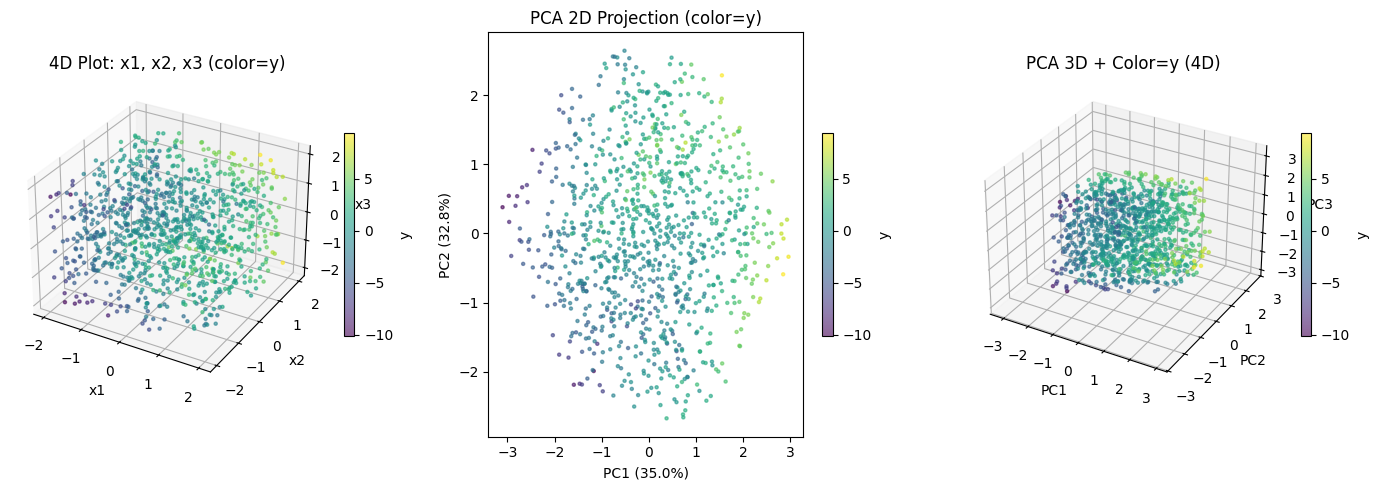

PCA explained variance ratios (3 components): [0.34959724 0.32788895 0.32251381]
Total variance explained: 100.0%


In [3]:
# ============================================================
# Section 3: 4D Plot Using PCA Dimensionality Reduction
# ============================================================
# Use PCA to reduce 3 input dimensions for visualization
# Color represents the target value y (4th dimension)

fig = plt.figure(figsize=(14, 5))

# Plot 1: Original 3D scatter with y as color (4D visualization)
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=y.flatten(),
                       cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('x3')
ax1.set_title('4D Plot: x1, x2, x3 (color=y)')
plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='y')

# Plot 2: PCA reduced to 2 components + y as color
pca_2d = PCA(n_components=2)
X_pca2 = pca_2d.fit_transform(X)
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y.flatten(),
                       cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_title('PCA 2D Projection (color=y)')
plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='y')

# Plot 3: PCA 3D with y as color (4D representation)
pca_3d = PCA(n_components=3)
X_pca3 = pca_3d.fit_transform(X)
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2],
                       c=y.flatten(), cmap='viridis', s=5, alpha=0.6)
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.set_title('PCA 3D + Color=y (4D)')
plt.colorbar(scatter3, ax=ax3, shrink=0.5, label='y')

plt.tight_layout()
plt.savefig('4d_data_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"PCA explained variance ratios (3 components): {pca_3d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_3d.explained_variance_ratio_)*100:.1f}%")

In [4]:
# ============================================================
# Section 4: Neural Network - Weight Initialization & Architecture
# ============================================================
# 3-Layer Deep Neural Network Architecture:
# Input(3) -> Hidden1(64, ReLU) -> Hidden2(32, ReLU) -> Hidden3(16, ReLU) -> Output(1, Linear)

def he_init(fan_in, fan_out):
    """He initialization for ReLU activation functions."""
    std = np.sqrt(2.0 / fan_in)
    return np.random.randn(fan_in, fan_out) * std

# Network architecture
LAYER_DIMS = [3, 64, 32, 16, 1]  # Input -> H1 -> H2 -> H3 -> Output

# Initialize weights and biases using He initialization
np.random.seed(42)
params = {}
for l in range(1, len(LAYER_DIMS)):
    params[f'W{l}'] = he_init(LAYER_DIMS[l-1], LAYER_DIMS[l])
    params[f'b{l}'] = np.zeros((1, LAYER_DIMS[l]))

print("Network Architecture:")
print("=" * 50)
layer_names = ['Input', 'Hidden 1 (ReLU)', 'Hidden 2 (ReLU)', 'Hidden 3 (ReLU)', 'Output (Linear)']
total_params = 0
for l in range(len(LAYER_DIMS)):
    print(f"  {layer_names[l]}: {LAYER_DIMS[l]} neurons")
    if l > 0:
        n_params = LAYER_DIMS[l-1] * LAYER_DIMS[l] + LAYER_DIMS[l]
        total_params += n_params
        print(f"    W{l}: {params[f'W{l}'].shape}, b{l}: {params[f'b{l}'].shape} ({n_params} params)")
print(f"\nTotal trainable parameters: {total_params}")

Network Architecture:
  Input: 3 neurons
  Hidden 1 (ReLU): 64 neurons
    W1: (3, 64), b1: (1, 64) (256 params)
  Hidden 2 (ReLU): 32 neurons
    W2: (64, 32), b2: (1, 32) (2080 params)
  Hidden 3 (ReLU): 16 neurons
    W3: (32, 16), b3: (1, 16) (528 params)
  Output (Linear): 1 neurons
    W4: (16, 1), b4: (1, 1) (17 params)

Total trainable parameters: 2881


In [5]:
# ============================================================
# Section 5: Activation Functions and Their Derivatives
# ============================================================

def relu(z):
    """ReLU activation: max(0, z)"""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU: 1 if z > 0, else 0"""
    return (z > 0).astype(float)

def linear(z):
    """Linear activation (identity) for output layer"""
    return z

def linear_derivative(z):
    """Derivative of linear activation is 1"""
    return np.ones_like(z)

# Test activation functions
test_z = np.array([-2, -1, 0, 1, 2])
print(f"Test input z:      {test_z}")
print(f"ReLU(z):           {relu(test_z)}")
print(f"ReLU_deriv(z):     {relu_derivative(test_z)}")
print(f"Linear(z):         {linear(test_z)}")
print(f"Linear_deriv(z):   {linear_derivative(test_z)}")

Test input z:      [-2 -1  0  1  2]
ReLU(z):           [0 0 0 1 2]
ReLU_deriv(z):     [0. 0. 0. 1. 1.]
Linear(z):         [-2 -1  0  1  2]
Linear_deriv(z):   [1 1 1 1 1]


In [6]:
# ============================================================
# Section 6: Forward Pass using tf.einsum
# ============================================================
# We use tf.einsum for ALL matrix multiplications instead of np.dot or np.matmul
# einsum('ij,jk->ik', A, B) is equivalent to A @ B

def forward_pass(X_batch, params):
    """
    Forward propagation through 3 hidden layers + output layer.
    Uses tf.einsum for matrix multiplication.

    Returns:
        cache: dict with all intermediate values needed for backprop
    """
    cache = {'A0': X_batch}  # Input is the 0th activation

    # Hidden Layer 1: Z1 = X @ W1 + b1, A1 = ReLU(Z1)
    Z1 = tf.einsum('ij,jk->ik', X_batch, params['W1']).numpy() + params['b1']
    A1 = relu(Z1)
    cache['Z1'], cache['A1'] = Z1, A1

    # Hidden Layer 2: Z2 = A1 @ W2 + b2, A2 = ReLU(Z2)
    Z2 = tf.einsum('ij,jk->ik', A1, params['W2']).numpy() + params['b2']
    A2 = relu(Z2)
    cache['Z2'], cache['A2'] = Z2, A2

    # Hidden Layer 3: Z3 = A2 @ W3 + b3, A3 = ReLU(Z3)
    Z3 = tf.einsum('ij,jk->ik', A2, params['W3']).numpy() + params['b3']
    A3 = relu(Z3)
    cache['Z3'], cache['A3'] = Z3, A3

    # Output Layer: Z4 = A3 @ W4 + b4, A4 = Linear(Z4)
    Z4 = tf.einsum('ij,jk->ik', A3, params['W4']).numpy() + params['b4']
    A4 = linear(Z4)
    cache['Z4'], cache['A4'] = Z4, A4

    return A4, cache

# Test forward pass
y_pred_test, cache_test = forward_pass(X_train[:5], params)
print("Forward pass test (first 5 samples):")
print(f"  Input shape:  {X_train[:5].shape}")
print(f"  A1 shape:     {cache_test['A1'].shape}")
print(f"  A2 shape:     {cache_test['A2'].shape}")
print(f"  A3 shape:     {cache_test['A3'].shape}")
print(f"  Output shape: {y_pred_test.shape}")
print(f"  Predictions:  {y_pred_test.flatten()}")

Forward pass test (first 5 samples):
  Input shape:  (5, 3)
  A1 shape:     (5, 64)
  A2 shape:     (5, 32)
  A3 shape:     (5, 16)
  Output shape: (5, 1)
  Predictions:  [-0.4183365   0.69722096  0.11873779  0.33953459 -0.66585689]


In [7]:
# ============================================================
# Section 7: Loss Function (MSE)
# ============================================================

def mse_loss(y_true, y_pred):
    """Mean Squared Error loss function."""
    return np.mean((y_true - y_pred) ** 2)

def mse_loss_derivative(y_true, y_pred):
    """Derivative of MSE w.r.t. predictions: d(MSE)/d(y_pred) = 2*(y_pred - y_true)/N"""
    N = y_true.shape[0]
    return 2.0 * (y_pred - y_true) / N

# Test loss
test_loss = mse_loss(y_train[:5], y_pred_test)
print(f"Initial test loss (5 samples): {test_loss:.6f}")

Initial test loss (5 samples): 0.760592


In [8]:
# ============================================================
# Section 8: Backward Pass - Manual Backpropagation with Chain Rule
# ============================================================
# Using tf.einsum for all matrix multiplications in backprop too

def backward_pass(y_true, y_pred, cache, params):
    """
    Manual backpropagation using chain rule.
    Computes gradients for all weights and biases.
    Uses tf.einsum for matrix multiplications.

    Chain Rule Flow:
    dL/dW4 = dL/dA4 * dA4/dZ4 * dZ4/dW4
    dL/dW3 = dL/dA4 * dA4/dZ4 * dZ4/dA3 * dA3/dZ3 * dZ3/dW3
    dL/dW2 = ... (chain continues)
    dL/dW1 = ... (chain continues further)
    """
    N = y_true.shape[0]
    grads = {}

    # ---- Output Layer (Layer 4) Gradients ----
    # dL/dZ4 = dL/dA4 * dA4/dZ4
    dA4 = mse_loss_derivative(y_true, y_pred)  # (N, 1)
    dZ4 = dA4 * linear_derivative(cache['Z4'])  # (N, 1)

    # dL/dW4 = A3^T @ dZ4 using einsum
    grads['dW4'] = tf.einsum('ji,jk->ik', cache['A3'], dZ4).numpy()  # (16, 1)
    grads['db4'] = np.sum(dZ4, axis=0, keepdims=True)  # (1, 1)

    # ---- Hidden Layer 3 Gradients ----
    # dL/dA3 = dZ4 @ W4^T
    dA3 = tf.einsum('ij,kj->ik', dZ4, params['W4']).numpy()  # (N, 16)
    # dL/dZ3 = dL/dA3 * dA3/dZ3 (chain rule)
    dZ3 = dA3 * relu_derivative(cache['Z3'])  # (N, 16)

    # dL/dW3 = A2^T @ dZ3
    grads['dW3'] = tf.einsum('ji,jk->ik', cache['A2'], dZ3).numpy()  # (32, 16)
    grads['db3'] = np.sum(dZ3, axis=0, keepdims=True)  # (1, 16)

    # ---- Hidden Layer 2 Gradients ----
    # dL/dA2 = dZ3 @ W3^T
    dA2 = tf.einsum('ij,kj->ik', dZ3, params['W3']).numpy()  # (N, 32)
    # dL/dZ2 = dL/dA2 * dA2/dZ2 (chain rule)
    dZ2 = dA2 * relu_derivative(cache['Z2'])  # (N, 32)

    # dL/dW2 = A1^T @ dZ2
    grads['dW2'] = tf.einsum('ji,jk->ik', cache['A1'], dZ2).numpy()  # (64, 32)
    grads['db2'] = np.sum(dZ2, axis=0, keepdims=True)  # (1, 32)

    # ---- Hidden Layer 1 Gradients ----
    # dL/dA1 = dZ2 @ W2^T
    dA1 = tf.einsum('ij,kj->ik', dZ2, params['W2']).numpy()  # (N, 64)
    # dL/dZ1 = dL/dA1 * dA1/dZ1 (chain rule)
    dZ1 = dA1 * relu_derivative(cache['Z1'])  # (N, 64)

    # dL/dW1 = X^T @ dZ1
    grads['dW1'] = tf.einsum('ji,jk->ik', cache['A0'], dZ1).numpy()  # (3, 64)
    grads['db1'] = np.sum(dZ1, axis=0, keepdims=True)  # (1, 64)

    return grads

# Test backward pass
grads_test = backward_pass(y_train[:5], y_pred_test, cache_test, params)
print("Backward pass gradient shapes:")
for key, val in grads_test.items():
    print(f"  {key}: {val.shape}")

Backward pass gradient shapes:
  dW4: (16, 1)
  db4: (1, 1)
  dW3: (32, 16)
  db3: (1, 16)
  dW2: (64, 32)
  db2: (1, 32)
  dW1: (3, 64)
  db1: (1, 64)


In [9]:
# ============================================================
# Section 9: Training Loop with Mini-Batch Gradient Descent
# ============================================================

# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 500
BATCH_SIZE = 64

# Re-initialize weights
np.random.seed(42)
params = {}
for l in range(1, len(LAYER_DIMS)):
    params[f'W{l}'] = he_init(LAYER_DIMS[l-1], LAYER_DIMS[l])
    params[f'b{l}'] = np.zeros((1, LAYER_DIMS[l]))

# Training history
train_losses = []
test_losses = []

print(f"Training Configuration:")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"\nTraining...")
print("=" * 60)

for epoch in range(EPOCHS):
    # Shuffle training data
    indices = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]

    epoch_loss = 0
    n_batches = 0

    # Mini-batch training
    for i in range(0, X_train.shape[0], BATCH_SIZE):
        X_batch = X_shuffled[i:i+BATCH_SIZE]
        y_batch = y_shuffled[i:i+BATCH_SIZE]

        # Forward pass
        y_pred, cache = forward_pass(X_batch, params)

        # Compute loss
        batch_loss = mse_loss(y_batch, y_pred)
        epoch_loss += batch_loss
        n_batches += 1

        # Backward pass (manual backprop with chain rule)
        grads = backward_pass(y_batch, y_pred, cache, params)

        # Update parameters (gradient descent)
        for l in range(1, len(LAYER_DIMS)):
            params[f'W{l}'] -= LEARNING_RATE * grads[f'dW{l}']
            params[f'b{l}'] -= LEARNING_RATE * grads[f'db{l}']

    # Record training loss
    avg_train_loss = epoch_loss / n_batches
    train_losses.append(avg_train_loss)

    # Compute test loss
    y_test_pred, _ = forward_pass(X_test, params)
    test_loss = mse_loss(y_test, y_test_pred)
    test_losses.append(test_loss)

    # Print progress
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:4d}/{EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Test Loss: {test_loss:.6f}")

print("=" * 60)
print(f"Training complete!")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss:  {test_losses[-1]:.6f}")

Training Configuration:
  Learning Rate: 0.001
  Epochs: 500
  Batch Size: 64
  Training samples: 800
  Test samples: 200

Training...
Epoch [   1/500] | Train Loss: 0.830833 | Test Loss: 0.690918
Epoch [  50/500] | Train Loss: 0.195242 | Test Loss: 0.181001
Epoch [ 100/500] | Train Loss: 0.115096 | Test Loss: 0.107031
Epoch [ 150/500] | Train Loss: 0.081236 | Test Loss: 0.077878
Epoch [ 200/500] | Train Loss: 0.069144 | Test Loss: 0.065339
Epoch [ 250/500] | Train Loss: 0.063171 | Test Loss: 0.059266
Epoch [ 300/500] | Train Loss: 0.058715 | Test Loss: 0.055899
Epoch [ 350/500] | Train Loss: 0.056442 | Test Loss: 0.053058
Epoch [ 400/500] | Train Loss: 0.054324 | Test Loss: 0.051093
Epoch [ 450/500] | Train Loss: 0.052494 | Test Loss: 0.049354
Epoch [ 500/500] | Train Loss: 0.050738 | Test Loss: 0.047777
Training complete!
Final Train Loss: 0.050738
Final Test Loss:  0.047777


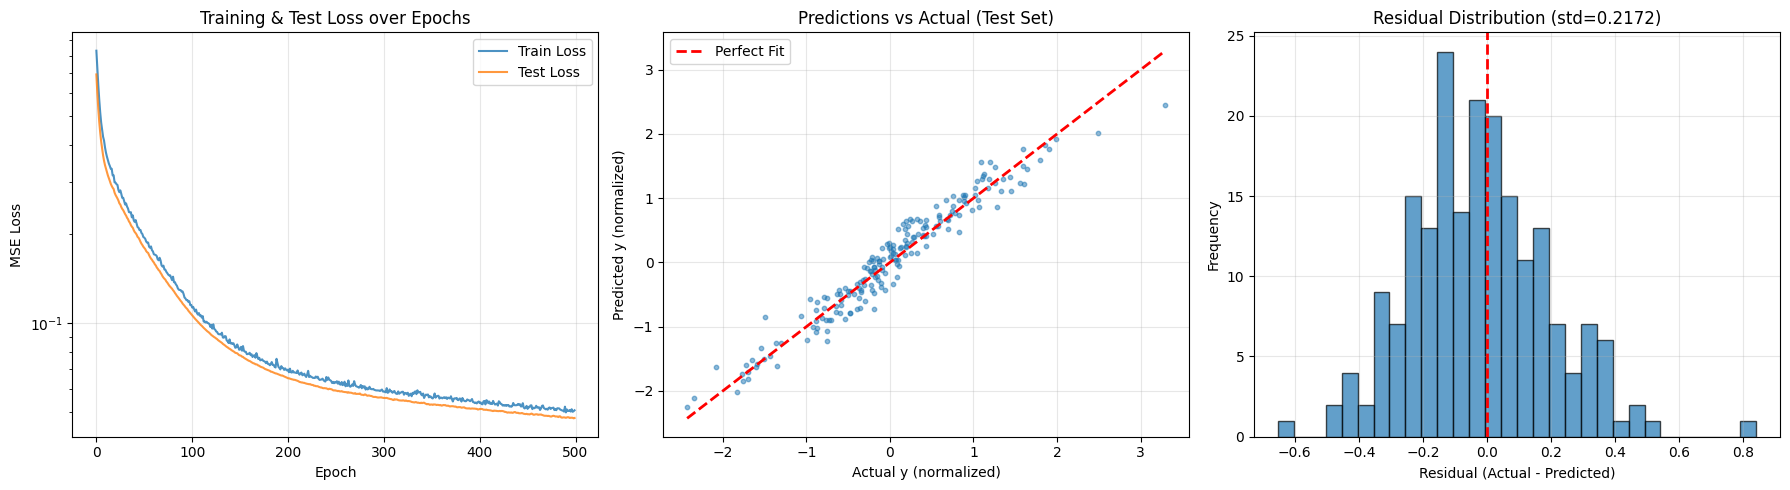


R-squared (Test): 0.941830
Mean Absolute Error (Test): 0.172168


In [10]:
# ============================================================
# Section 10: Training Results Visualization
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Loss curves
axes[0].plot(train_losses, label='Train Loss', alpha=0.8)
axes[0].plot(test_losses, label='Test Loss', alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training & Test Loss over Epochs')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual (test set)
y_final_pred, _ = forward_pass(X_test, params)
axes[1].scatter(y_test, y_final_pred, alpha=0.5, s=10)
min_val = min(y_test.min(), y_final_pred.min())
max_val = max(y_test.max(), y_final_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[1].set_xlabel('Actual y (normalized)')
axes[1].set_ylabel('Predicted y (normalized)')
axes[1].set_title('Predictions vs Actual (Test Set)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Residuals distribution
residuals = (y_test - y_final_pred).flatten()
axes[2].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residual (Actual - Predicted)')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Residual Distribution (std={residuals.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

# R-squared score
ss_res = np.sum((y_test - y_final_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"\nR-squared (Test): {r_squared:.6f}")
print(f"Mean Absolute Error (Test): {np.mean(np.abs(residuals)):.6f}")

In [11]:
# ============================================================
# Section 11: Final Output - Sample Predictions
# ============================================================

# Denormalize predictions for actual scale
y_test_actual = y_test * y_std + y_mean
y_pred_actual = y_final_pred * y_std + y_mean

print("\nSample Predictions (Denormalized - Original Scale):")
print("=" * 70)
print(f"{'Index':>6} | {'x1':>8} | {'x2':>8} | {'x3':>8} | {'Actual y':>10} | {'Predicted':>10} | {'Error':>8}")
print("-" * 70)

# Denormalize X for display
X_test_actual = X_test * X_std + X_mean

for i in range(min(15, len(y_test))):
    actual = y_test_actual[i, 0]
    pred = y_pred_actual[i, 0]
    error = abs(actual - pred)
    print(f"{i:6d} | {X_test_actual[i,0]:8.3f} | {X_test_actual[i,1]:8.3f} | {X_test_actual[i,2]:8.3f} | {actual:10.4f} | {pred:10.4f} | {error:8.4f}")

print("\n" + "=" * 70)
print(f"Overall MAE (original scale): {np.mean(np.abs(y_test_actual - y_pred_actual)):.4f}")
print(f"Overall RMSE (original scale): {np.sqrt(np.mean((y_test_actual - y_pred_actual)**2)):.4f}")
print(f"R-squared: {r_squared:.6f}")


Sample Predictions (Denormalized - Original Scale):
 Index |       x1 |       x2 |       x3 |   Actual y |  Predicted |    Error
----------------------------------------------------------------------
     0 |    0.829 |    1.826 |    1.170 |     5.2825 |     5.1805 |   0.1020
     1 |   -1.390 |    0.950 |    1.632 |     1.7257 |     1.8412 |   0.1155
     2 |    0.305 |   -0.587 |    1.775 |    -1.8073 |    -2.1751 |   0.3678
     3 |    0.427 |   -0.814 |    1.841 |    -2.5965 |    -2.8513 |   0.2548
     4 |   -0.303 |   -0.601 |    0.086 |    -0.4148 |    -0.5934 |   0.1786
     5 |    0.946 |    1.099 |    1.909 |     4.6694 |     4.1331 |   0.5363
     6 |    1.737 |    0.645 |    1.029 |     1.9903 |     1.5108 |   0.4795
     7 |    1.702 |   -1.259 |   -1.353 |    -0.3670 |     0.0731 |   0.4400
     8 |   -0.197 |   -1.304 |   -0.092 |    -0.5389 |    -0.2074 |   0.3315
     9 |   -1.547 |   -1.606 |    0.873 |    -4.7987 |    -5.1129 |   0.3142
    10 |    1.939 |    0.641 

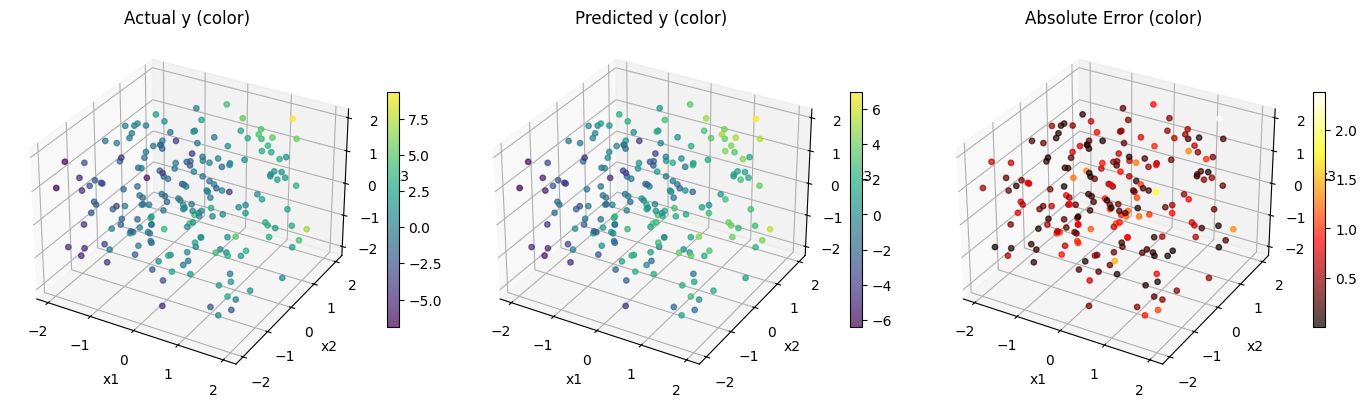


=== Colab A Complete ===
Summary:
- 3-layer deep neural network built from scratch with NumPy
- tf.einsum used for all matrix multiplications
- Manual backpropagation with chain rule
- 3-variable non-linear regression
- 4D visualization using PCA and color mapping


In [12]:
# ============================================================
# Section 12: 4D Plot of Predictions vs Actual
# ============================================================

fig = plt.figure(figsize=(14, 5))

# Actual values 4D plot
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(X_test_actual[:, 0], X_test_actual[:, 1], X_test_actual[:, 2],
                       c=y_test_actual.flatten(), cmap='viridis', s=15, alpha=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('x3')
ax1.set_title('Actual y (color)')
plt.colorbar(scatter1, ax=ax1, shrink=0.5)

# Predicted values 4D plot
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(X_test_actual[:, 0], X_test_actual[:, 1], X_test_actual[:, 2],
                       c=y_pred_actual.flatten(), cmap='viridis', s=15, alpha=0.7)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('x3')
ax2.set_title('Predicted y (color)')
plt.colorbar(scatter2, ax=ax2, shrink=0.5)

# Error 4D plot
ax3 = fig.add_subplot(133, projection='3d')
error_vals = np.abs(y_test_actual - y_pred_actual).flatten()
scatter3 = ax3.scatter(X_test_actual[:, 0], X_test_actual[:, 1], X_test_actual[:, 2],
                       c=error_vals, cmap='hot', s=15, alpha=0.7)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('x3')
ax3.set_title('Absolute Error (color)')
plt.colorbar(scatter3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.savefig('4d_predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Colab A Complete ===")
print("Summary:")
print("- 3-layer deep neural network built from scratch with NumPy")
print("- tf.einsum used for all matrix multiplications")
print("- Manual backpropagation with chain rule")
print("- 3-variable non-linear regression")
print("- 4D visualization using PCA and color mapping")